# German Credit data Exploration and Prediction

This Analysis can be divided into 6 parts:

1. Data Loading

2. Data Exploration

3. Data Preprocessing

4. Building a Model

5. Conclusion


We will start with Loading the required Libraries and methods

In [74]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as  hub
import tensorflow_datasets as tfds
import numpy as np
import csv
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree  import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from collections import OrderedDict
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
# magic word for producing visualizations in notebook
warnings.filterwarnings('ignore')
%matplotlib inline

In [75]:
def groupby_requirement(df, column, value):
    grouped_data = df.groupby([column]).get_group(value)
    length = len(grouped_data)
    return grouped_data , length

In [76]:
def age_count(df):
    young = 0
    old = 0 
    for i in df['Age']:
        if i <= 30:
            young += 1
        else:
            old += 1
    return young, old

In [77]:
def GridSCV_check(Classifier, parameters, X_train, y_train, X_test, y_test):
    #clf = RandomForestClassifier()
    #parameters = {"max_depth" : [1,10,100], 
    #              "min_samples_split" : [6, 8, 10, 12], 
    #              "min_samples_leaf" : [3,4,5]}
    clf = Classifier
    #fbeta_score scoring object using make_scorer()
    scorer = make_scorer(fbeta_score, beta=2)
    #Grid search on the classifier
    grid_obj = GridSearchCV(clf, parameters, scoring = scorer)
    #Fit the grid search object to the training data
    grid_fit = grid_obj.fit(X_train, y_train)
    # Get the estimator
    best_clf = grid_fit.best_estimator_
    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)

    # Report the before-and-afterscores
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 2)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 2)))
    return None

In [78]:
def plot_graph(C1, C2, R1, R2, I1, I2, N1, N2):
    study_dataframe = pd.DataFrame(                         
        data={N1:[C1, C2],
              N2:[R1, R2]},
        index=[I1, I2])
    study_dataframe.plot.bar(alpha=0.7)
    plt.ylabel("Total Count")
    return None

## 1. Data Loading

First we will load the data from the german.data provided by UCI. The Column value are hardcoded as they are not present in the dataset

In [79]:
file = '../german.data'
columns = ['Existing account', 
           'Duration month', 
           'Credit history',
           'Purpose',
           'Credit amount',
           'Saving',
           'Employment duration',
           'Installment rate',
           'Personal status',
           'Debtors',
           'Residential Duration',
           'Property',
           'Age',
           'Installment plans',
           'Housing',
           'Number of credits',
           'Job',
           'Liable People',
           'Telephone',
           'Foreign worker',
           'Classification'
          ]
customers = pd.read_csv(file, names = columns, delimiter = ' ')
customers.head()

,Existing account,Duration month,Credit history,Purpose,Credit amount,Saving,Employment duration,Installment rate,Personal status,Debtors,...,Property,Age,Installment plans,Housing,Number of credits,Job,Liable People,Telephone,Foreign worker,Classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [80]:
#Let us do some basic exploration amount the number of 
classification_count = customers.groupby('Classification').count()
classification_count['Existing account']

Classification
1    700
2    300
Name: Existing account, dtype: int64

In [81]:
#Checking if there are any missing values
customers.isnull().sum()

Existing account        0
Duration month          0
Credit history          0
Purpose                 0
Credit amount           0
Saving                  0
Employment duration     0
Installment rate        0
Personal status         0
Debtors                 0
Residential Duration    0
Property                0
Age                     0
Installment plans       0
Housing                 0
Number of credits       0
Job                     0
Liable People           0
Telephone               0
Foreign worker          0
Classification          0
dtype: int64

## 2. Data Exploration

Now we will try to do some data exploration to find meaningful information and along with that will answer the questions asked in the problem statement

### 2.1 Critical Credit History

In [82]:
# We will group Customers according to their classifications First
good_customers, good_customer_length = groupby_requirement(customers, 'Classification', 1)
bad_customers, bad_customer_length = groupby_requirement(customers, 'Classification', 2)

# Now let us try to see each group separately
good_critical_customers , good_critical_customers_length =  groupby_requirement(good_customers, 'Credit history', 'A34')
bad_critical_customers , bad_critical_customers_length= groupby_requirement(bad_customers, 'Credit history', 'A34')

# Let us try to find the percentage of Customers with Critical Credit history with 
# their respective groups
to_print_value = ((good_critical_customers_length/good_customer_length)*100)
print ('Percentage of Good customers with Critical credit History : {}'.format(to_print_value))
to_print_value = ((bad_critical_customers_length/ bad_customer_length)*100)
print ('Percentage of Bad customers with Critical credit History : {}'.format(to_print_value))

# This will print the percentage Good customers with Critical History with 
# respect to all Customers with Critical History
to_print_value =  ((good_critical_customers_length /
                   (good_critical_customers_length + bad_critical_customers_length)) * 100)
print ('Percentage of Good customers with critical credit history out of all customers '
       'with critical credit history : {}'.format(to_print_value))

Percentage of Good customers with Critical credit History : 34.714285714285715
Percentage of Bad customers with Critical credit History : 16.666666666666664
Percentage of Good customers with critical credit history out of all customers with critical credit history : 82.93515358361775


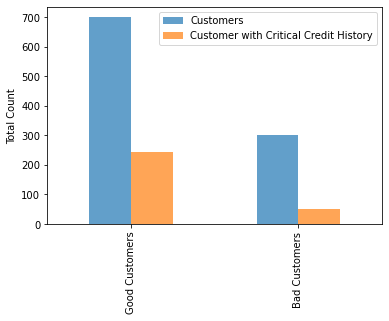

In [83]:
plot_graph(good_customer_length,
           bad_customer_length, 
           good_critical_customers_length, 
           bad_critical_customers_length,
           'Good Customers', 
           'Bad Customers',
           'Customers',
           'Customer with Critical Credit History')

#### Would a person with critical credit history, be more credit worthy?
    
>Here we can see that one of every three good customers have a Critical Credit History. On the other hand, one of every six bad customers have Critical Credit History. Also 4 out of 5 Customers with Critical Credit History are good customers. 
    
>So here we can infer that ***Yes, Critical Credit History indicates that a customer is more Credit worthy***. 

### 2.2 Age 

**Note**: Anyone below and equal to 30 years will be considered young and anyone above 30 years will be considered old

In [84]:
# Here will be categorize good customer according to the age
young_good_customers, old_good_customers = age_count(good_customers)
to_print_value = ((young_good_customers / ( young_good_customers + old_good_customers)) * 100)
print ('Percentage of good young customers out of all good customers : {}'.format(to_print_value))

# Here will be categorize bad customer according to the age
young_bad_customers , old_bad_customers = age_count(bad_customers)
to_print_value =((young_bad_customers / ( young_bad_customers + old_bad_customers)) * 100)
print ('Percentage of bad young customers out of all bad customers : {}'.format(to_print_value))

# Here try to find that what percentage of young customers are good
to_print_value = ((young_good_customers / (young_good_customers + young_bad_customers) )* 100)
print ('Percentage of good young customers out of all young customers : {}'.format(to_print_value))
# Here try to find that what percentage of old customers are good
to_print_value = ((old_good_customers / (old_good_customers + old_bad_customers) )* 100)
print ('Percentage of good old customers out of all old customers : {}'.format(to_print_value))

Percentage of good young customers out of all good customers : 37.57142857142857
Percentage of bad young customers out of all bad customers : 49.333333333333336
Percentage of good young customers out of all young customers : 63.990267639902676
Percentage of good old customers out of all old customers : 74.19354838709677


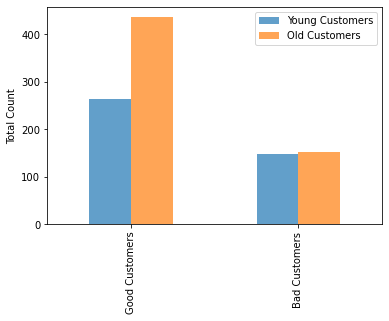

In [85]:
plot_graph(young_good_customers, 
           young_bad_customers,
           old_good_customers,
           old_bad_customers,
           'Good Customers',
           'Bad Customers',
           'Young Customers',
           'Old Customers'
           )

#### Are young people more credit worthy?
    
>Here we can see that 3 out of 4 Old Customers are Credit Worthy. On the other hand, 6 of every 10 young customers credit worthy. Also there is 50% chance that if the customer is categorised as bad customer then he/she is young. 
    
>So here we can infer that ***Old customers are more credit worthy than young people***. 

### 2.3 Credit accounts


In [86]:
# Let us see how many distinct values are present for number of Credits column
num = set(good_customers['Number of credits'])
num

{1, 2, 3, 4}

In [87]:
good_customers_with_3_credits, good_3_credit = groupby_requirement(good_customers, 'Number of credits', 3)
good_customers_with_4_credits, good_4_credit = groupby_requirement(good_customers, 'Number of credits', 4)

customers_with_3_credits, all_3_credit = groupby_requirement(customers, 'Number of credits', 3)
customers_with_4_credits, all_4_credit = groupby_requirement(customers, 'Number of credits', 4)

((good_3_credit + good_4_credit)/(all_3_credit + all_4_credit))*100
to_print_value = (((good_3_credit + good_4_credit)/(all_3_credit + all_4_credit))*100)
print ('Percentage of good customers with more than 3 credit accounts '
       'out of all customers with more that 3 credit accounts: {}'.format(to_print_value))

Percentage of good customers with more than 3 credit accounts out of all customers with more that 3 credit accounts: 76.47058823529412


#### Would a person with more credit accounts, be more credit worthy?
    
>Here we can see that 3 out of 4 good customer have more than 2 credit accounts. 
    
>So here we can infer that ***Customers with more than 2 credits accounts are credit worthy***.

### 2.4 Consolidated view of the data using Swarm graph

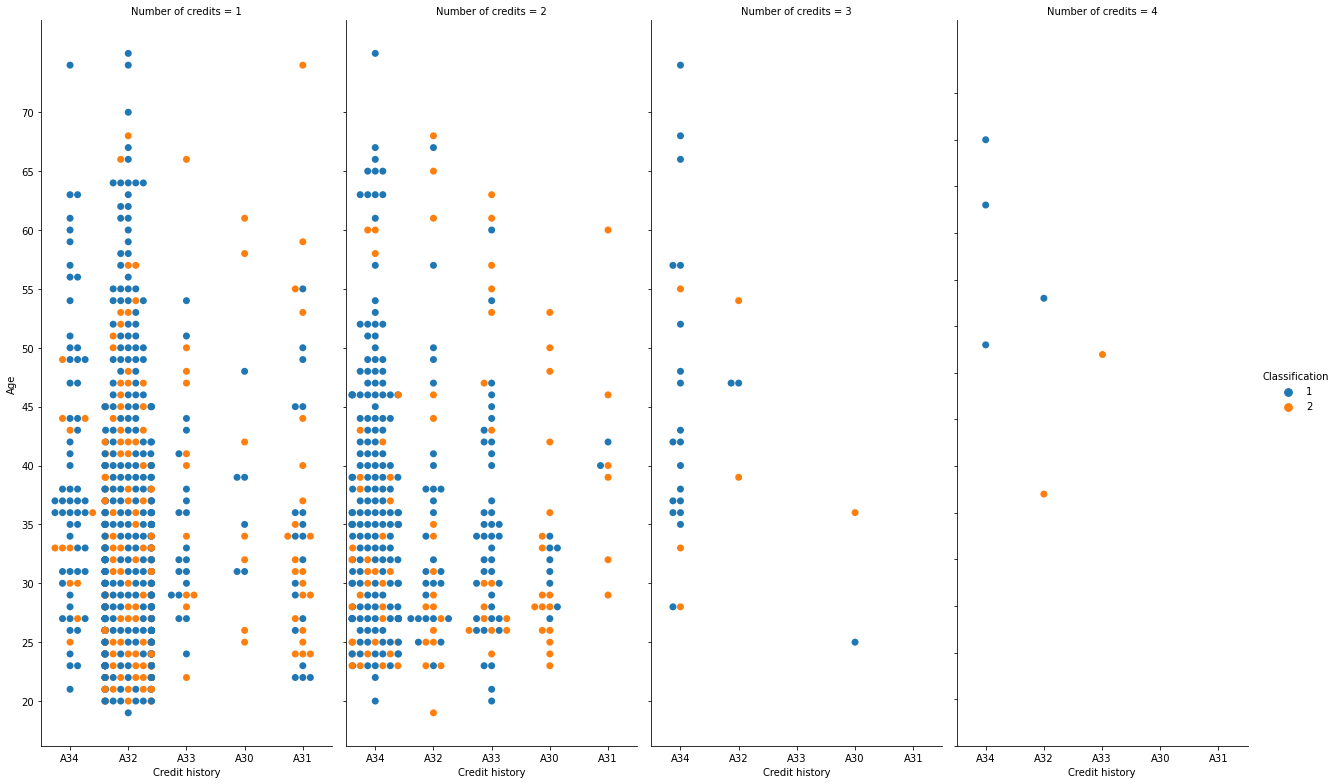

In [88]:
sns.factorplot(data=customers, 
               col='Number of credits', 
               x='Credit history', 
               y='Age', 
               hue='Classification', 
               kind='swarm', size=11, aspect=0.4, s=7)
plt.yticks(np.arange(0,75,5));

### Take away points from the graph above:
> **More the number of Credit accounts more the probabilility of Credit worthiness**

> **Critical credit History depict higher credit worthiness**

> **Anyone with two credit accounts with critical credit history(A34) and between the age 31 to 65 has high likelyhood of high credit worthiness**

## 3. Data Preprocessing 

In [89]:
#Separating Data from the Label
label = customers['Classification']
customers = customers.drop('Classification', axis = 1)
numeric_columns = customers.describe().columns

#### Now Let us plot pairplot graph to see correlation of the columns

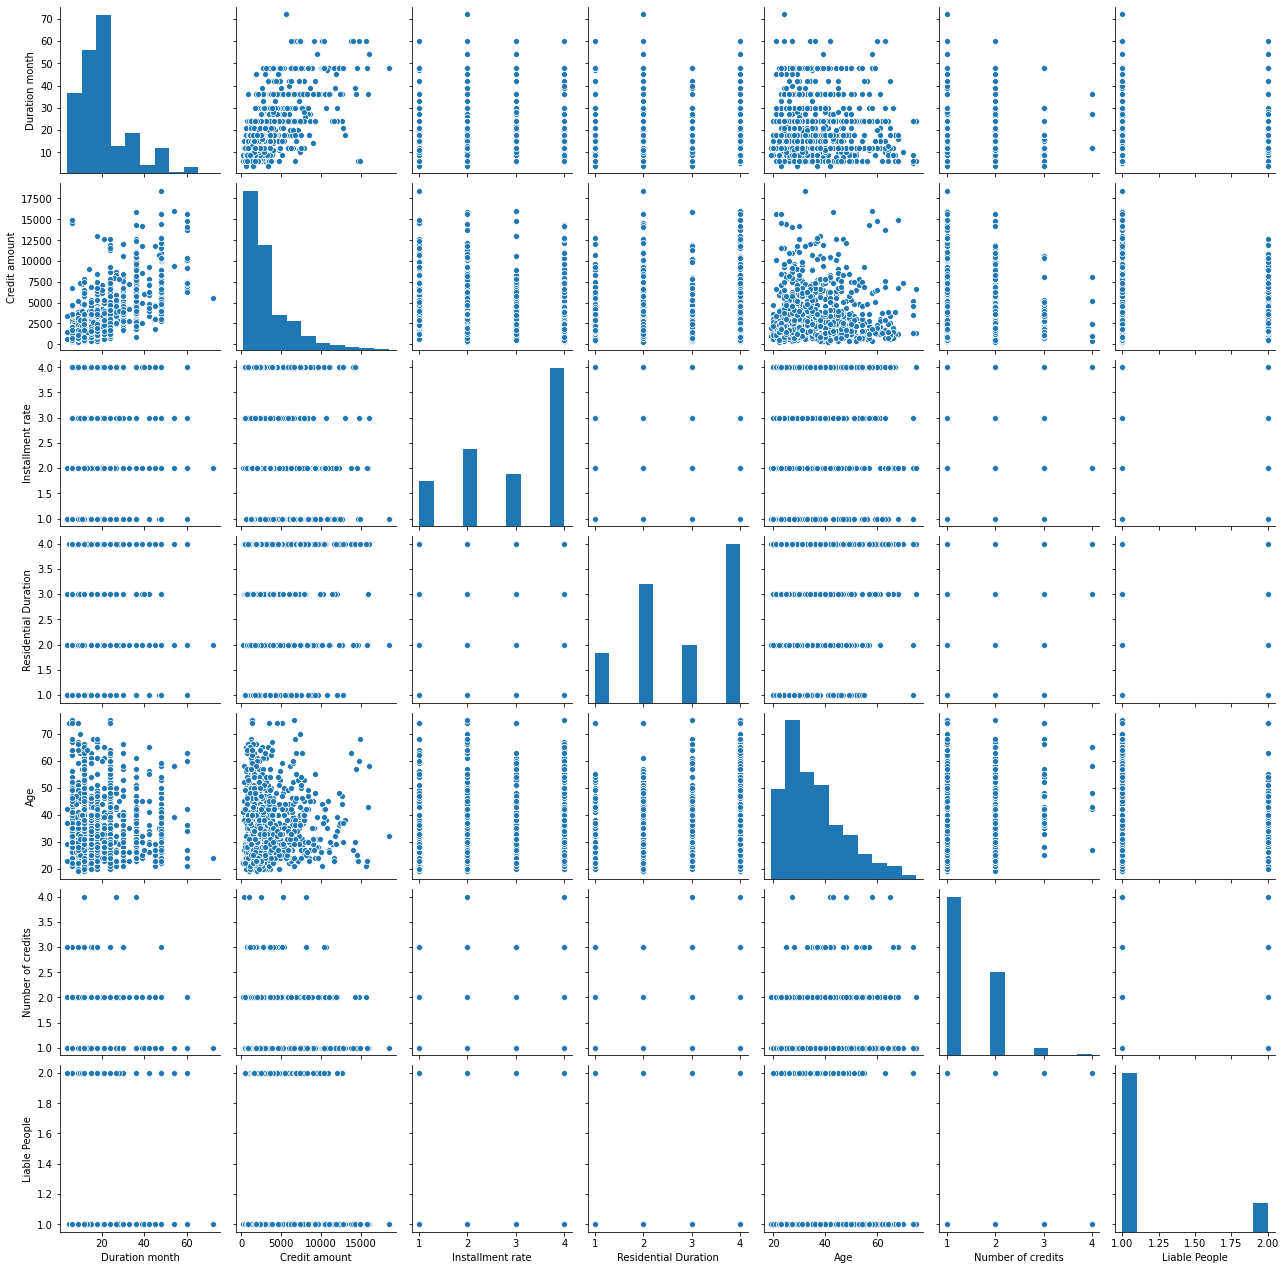

In [90]:
#Let us try to see if the columns in the dataframes are correlated
sns.pairplot(customers[numeric_columns])

#### From the Graph above we can notice a few things

> 1. Credit amount and Duration Month are directly related. So with increase of Duration month and Credit amount is also Increasing

> 2. Age along with Duration Month and Credit amount are right skewed with most of the datapoints located at the start of the graph

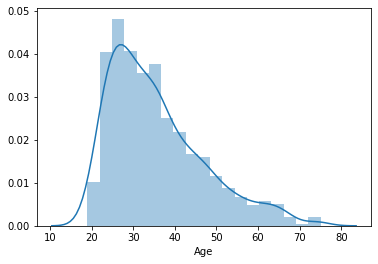

In [91]:
sns.distplot(customers['Age'])

##### The plot above is right skewed with one peak

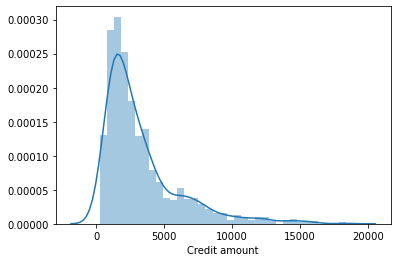

In [92]:
sns.distplot(customers['Credit amount'])

##### The plot above is also right skewed 

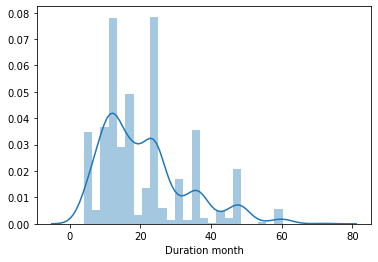

In [93]:
sns.distplot(customers['Duration month'])

##### The plot above is also right skewed with multiple peaks

### 3.1 Logarithmic Transform

> As noticed above there are columns with Skewed data. So we will preform Logarithmic transform to reduce the impact of very large or very small values on the learning Algorithm

In [94]:
# Here we will perform Log transform of all the numeric columns of create a redistributed graph
customers_log_transformed = customers.copy()
customers_log_transformed[numeric_columns] = customers[numeric_columns].apply(lambda x: np.log(x + 1))
customers_log_transformed

,Existing account,Duration month,Credit history,Purpose,Credit amount,Saving,Employment duration,Installment rate,Personal status,Debtors,Residential Duration,Property,Age,Installment plans,Housing,Number of credits,Job,Liable People,Telephone,Foreign worker
0,A11,1.945910,A34,A43,7.064759,A65,A75,1.609438,A93,A101,1.609438,A121,4.219508,A143,A152,1.098612,A173,0.693147,A192,A201
1,A12,3.891820,A32,A43,8.691483,A61,A73,1.098612,A92,A101,1.098612,A121,3.135494,A143,A152,0.693147,A173,0.693147,A191,A201
2,A14,2.564949,A34,A46,7.648263,A61,A74,1.098612,A93,A101,1.386294,A121,3.912023,A143,A152,0.693147,A172,1.098612,A191,A201
3,A11,3.761200,A32,A42,8.972464,A61,A74,1.098612,A93,A103,1.609438,A122,3.828641,A143,A153,0.693147,A173,1.098612,A191,A201
4,A11,3.218876,A33,A40,8.491055,A61,A73,1.386294,A93,A101,1.609438,A124,3.988984,A143,A153,1.098612,A173,1.098612,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,2.564949,A32,A42,7.459915,A61,A74,1.386294,A92,A101,1.609438,A121,3.465736,A143,A152,0.693147,A172,0.693147,A191,A201
996,A11,3.433987,A32,A41,8.257904,A61,A73,1.609438,A91,A101,1.609438,A122,3.713572,A143,A152,0.693147,A174,0.693147,A192,A201
997,A14,2.564949,A32,A43,6.690842,A61,A75,1.609438,A93,A101,1.609438,A123,3.663562,A143,A152,0.693147,A173,0.693147,A191,A201
998,A11,3.828641,A32,A43,7.520776,A61,A73,1.609438,A93,A101,1.609438,A124,3.178054,A143,A153,0.693147,A173,0.693147,A192,A201


##### Now let us Pairplot again to check if the distribution has been normalized

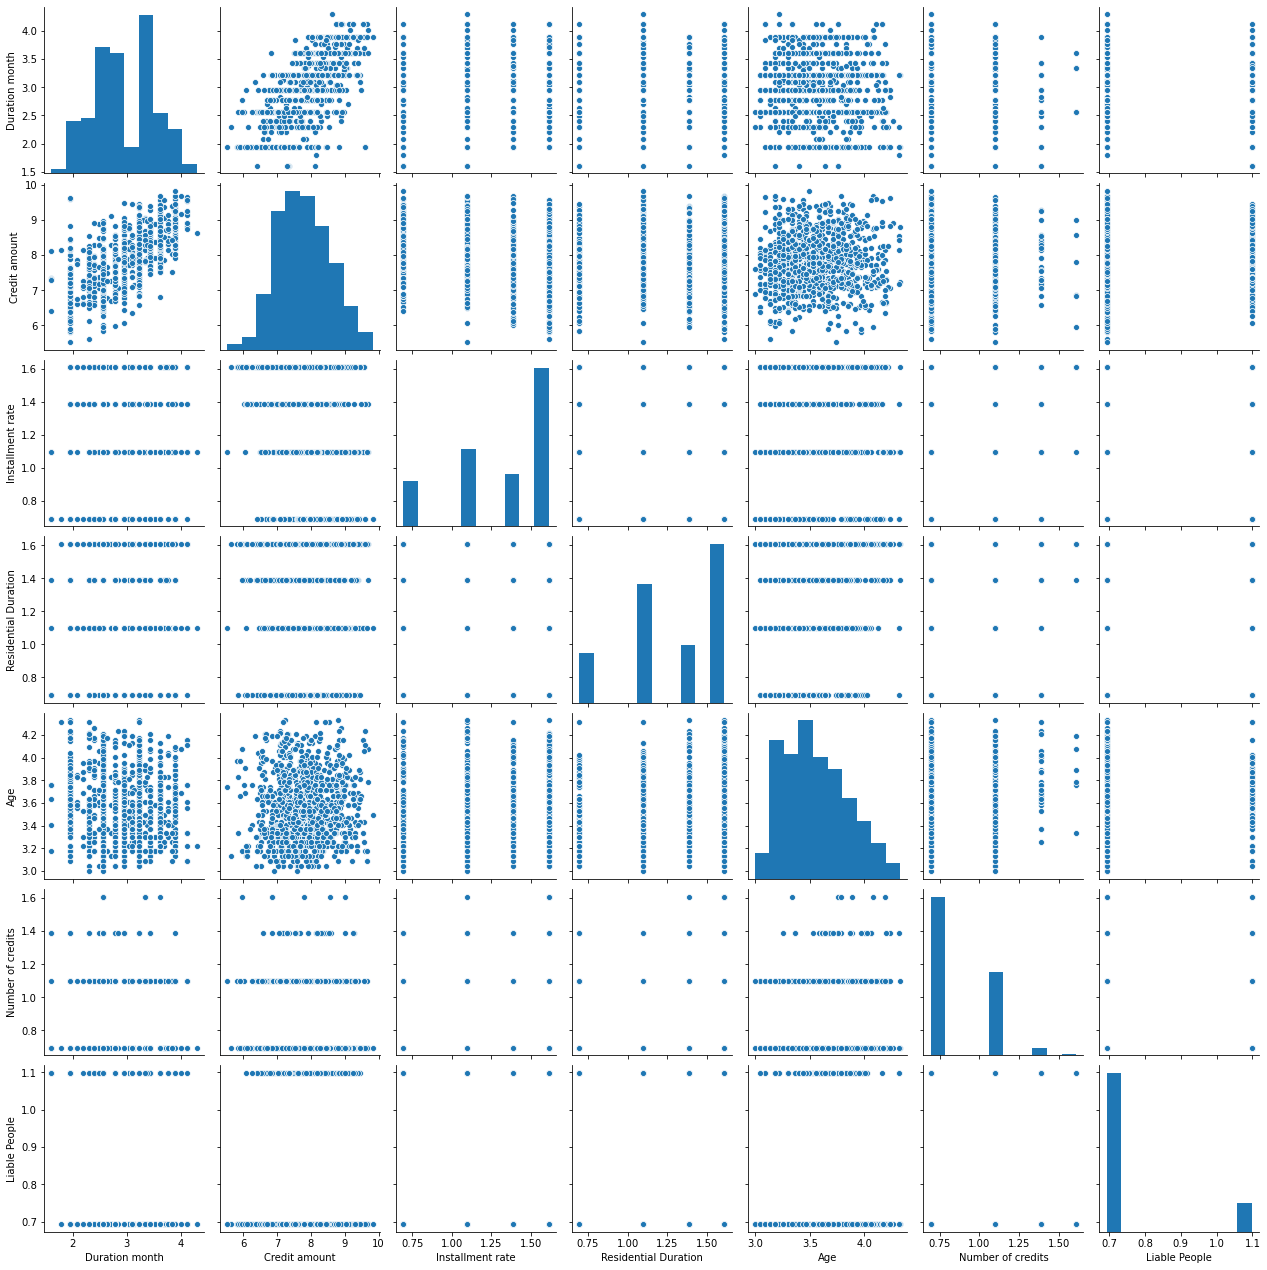

In [95]:
sns.pairplot(customers_log_transformed[numeric_columns])

### 3.2 Min Max Scaling

> As there are numeric values present in the data we will perform Min Max Scaling to normalize the data. There is another way of doing this know as **Standard Scaling** which uses Mean and Standard deviation to produce the normalized data

In [96]:
scaler = MinMaxScaler()
customers_scaled_log_transformed = customers_log_transformed.copy()
customers_scaled_log_transformed[numeric_columns] = scaler.fit_transform(customers_scaled_log_transformed[numeric_columns])
customers_scaled_log_transformed

,Existing account,Duration month,Credit history,Purpose,Credit amount,Saving,Employment duration,Installment rate,Personal status,Debtors,Residential Duration,Property,Age,Installment plans,Housing,Number of credits,Job,Liable People,Telephone,Foreign worker
0,A11,0.125502,A34,A43,0.358311,A65,A75,1.000000,A93,A101,1.000000,A121,0.916685,A143,A152,0.442507,A173,0.0,A192,A201
1,A12,0.851311,A32,A43,0.736970,A61,A73,0.442507,A92,A101,0.442507,A121,0.104691,A143,A152,0.000000,A173,0.0,A191,A201
2,A14,0.356398,A34,A46,0.494135,A61,A74,0.442507,A93,A101,0.756471,A121,0.686360,A143,A152,0.000000,A172,1.0,A191,A201
3,A11,0.802590,A32,A42,0.802375,A61,A74,0.442507,A93,A103,1.000000,A122,0.623901,A143,A153,0.000000,A173,1.0,A191,A201
4,A11,0.600308,A33,A40,0.690315,A61,A73,0.756471,A93,A101,1.000000,A124,0.744008,A143,A153,0.442507,A173,1.0,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,0.356398,A32,A42,0.450293,A61,A74,0.756471,A92,A101,1.000000,A121,0.352062,A143,A152,0.000000,A172,0.0,A191,A201
996,A11,0.680543,A32,A41,0.636044,A61,A73,1.000000,A91,A101,1.000000,A122,0.537707,A143,A152,0.000000,A174,0.0,A192,A201
997,A14,0.356398,A32,A43,0.271272,A61,A75,1.000000,A93,A101,1.000000,A123,0.500246,A143,A152,0.000000,A173,0.0,A191,A201
998,A11,0.827745,A32,A43,0.464460,A61,A73,1.000000,A93,A101,1.000000,A124,0.136570,A143,A153,0.000000,A173,0.0,A192,A201


### 3.3 One-Hot Encoding Data

> As there are a lot of non Numeric (categorical) columns. We will preform One-Hot Encoding to make the data Machine readable. We can also use **LabelEncoding** to convert Categorical column into machine readable data

In [97]:
customers_final = pd.get_dummies(customers_scaled_log_transformed)

In [98]:
len(customers_final.columns)

61

### 3.4 Splitting the data into Test and Train datasets

In [99]:
label -= 1

In [100]:
X_train, X_test, y_train, y_test = train_test_split(customers_final, 
                                                    label, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, 
                                                   y_train, 
                                                   test_size=0.25, 
                                                   random_state= 1)

In [101]:
X_test.to_csv('X_test.csv',index = False)
y_test.to_csv('y_test.csv',index = False)

## 4. Building a model

### 4.1 Create a model

In [102]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(61, activation='relu', input_shape=(61,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ]
    )
    model.compile(optimizer = 'adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                 )
    return model

In [103]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 61)                3782      
_________________________________________________________________
dropout_4 (Dropout)          (None, 61)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1860      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 62        
Total params: 5,704
Trainable params: 5,704
Non-trainable params: 0
_________________________________________________________________


### 4.2 Fit the model

In [104]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=45,
                    verbose=1,
                    batch_size=50)

Train on 600 samples, validate on 200 samples
Epoch 1/45
600/600 [==============================] - 1s 964us/sample - loss: 0.7472 - accuracy: 0.4800 - val_loss: 0.6046 - val_accuracy: 0.7300
Epoch 2/45
600/600 [==============================] - 0s 50us/sample - loss: 0.6514 - accuracy: 0.6133 - val_loss: 0.5652 - val_accuracy: 0.7300
Epoch 3/45
600/600 [==============================] - 0s 57us/sample - loss: 0.6301 - accuracy: 0.6667 - val_loss: 0.5525 - val_accuracy: 0.7300
Epoch 4/45
600/600 [==============================] - 0s 60us/sample - loss: 0.6095 - accuracy: 0.6750 - val_loss: 0.5449 - val_accuracy: 0.7300
Epoch 5/45
600/600 [==============================] - 0s 55us/sample - loss: 0.6197 - accuracy: 0.6667 - val_loss: 0.5397 - val_accuracy: 0.7300
Epoch 6/45
600/600 [==============================] - 0s 55us/sample - loss: 0.6143 - accuracy: 0.6700 - val_loss: 0.5304 - val_accuracy: 0.7300
Epoch 7/45
600/600 [==============================] - 0s 58us/sample - loss: 0.5769

### 4.3 Find Loss and Accuracy

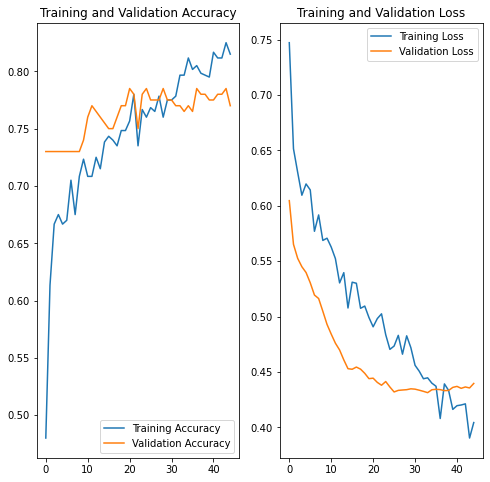

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(45)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./learning-colab.png')
plt.show()

### 4.4 Evaluate the model

In [106]:
[loss, mae] = model.evaluate(X_test, y_test, verbose=1)

200/200 [==============================] - 0s 439us/sample - loss: 0.5281 - accuracy: 0.7600


In [107]:
model.save('german_credit.h5')

In [108]:
#Creating Json file of X_tes
output= []
with open('X_test.csv','r') as f:
    reader = csv.DictReader(f, delimiter = ',')
    for i in reader:
        output.append(i)
with open('X_test_json.json','w')as outfile:
    json.dump(output,outfile,sort_keys=True, indent=4)

 ## 5.Conclusion

> In this exercise we performed Supervised Learning on German Credits data. Below is the complete process with findings in each step:

> First we performed **Exploratory data analysis** to check the data and the findings are as below:

>>  In the Segment 2.1 we concluded that **Critical Credit History indicates that a customer is more Credit worthy.**
>> In the Segment 2.2 we concluded that **old customers are more credit worthy than young people.**
>> In the Segment 2.3 we concluded that **Customers with more than 2 credits accounts are credit worthy**.
>> In the Segment 2.4 we concluded **Anyone with two credit accounts, with critical credit history(A34) and between the age 31 to 65 has high likelyhood of high credit worthiness**.

>  Then we performed **Data Preprocessing** and the findings are as below:

>> Few Columns had right Skewed distribition. So to reduce the range of outliers we performed **Logrithmic Transform** on the Numeric Data.
>> Then we performed **Min Max scaling** to normalize the data.
>> To make the data more Machine readable we did **One-Hot Encoding**

> After that we **Build a Tensorflow Model**

>> We used **Dense layer, dropout layer and Sigmoid Activation** to train the model.
>> To compile the model we used **Adam** optimizer, **Sparse Categorically Cross Entropy**  loss and **Accuracy** as metrics. 

> In the End we tested the model in test data to get 74 percent Accuracy. 